# Example of Filtering Embedded Pairs

In [2]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
import copy

sys.path.append('../..')
device = "cuda" if torch.cuda.is_available() else "cpu"

from LightningModules.Filter.Models.vanilla_filter import VanillaFilter
from LightningModules.Filter.Models.pyramid_filter import PyramidFilter

## Pytorch Lightning Model

### Construct PyLightning model

An ML model typically has many knobs to turn, as well as locations of data, some training preferences, and so on. For convenience, let's put all of these parameters into a YAML file and load it.

In [2]:
with open("example_filter.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
model = PyramidFilter(hparams)

## The Dataset

In [7]:
model.setup(stage="fit")

Loading data


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [13]:
trainset = model.trainset

In [16]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [17]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

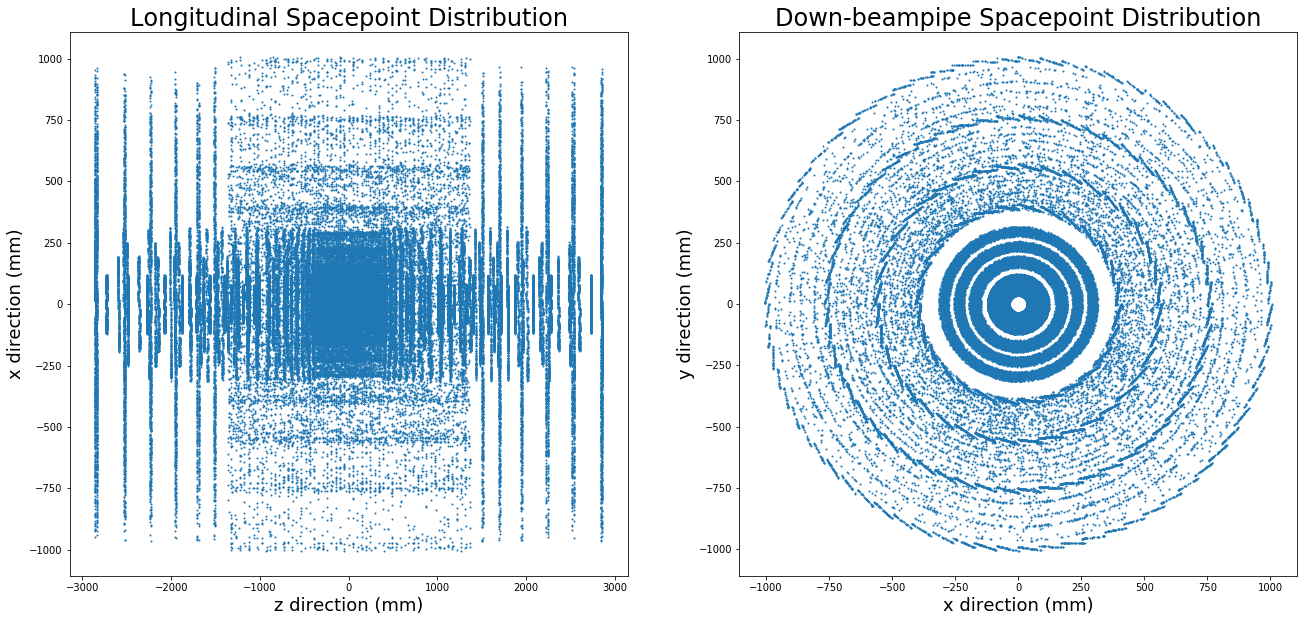

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

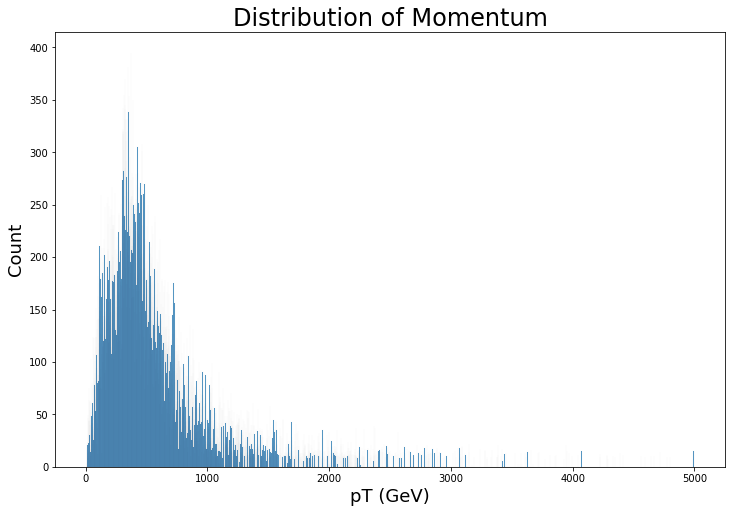

In [47]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.pt == example_data.pt], binwidth=200, binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

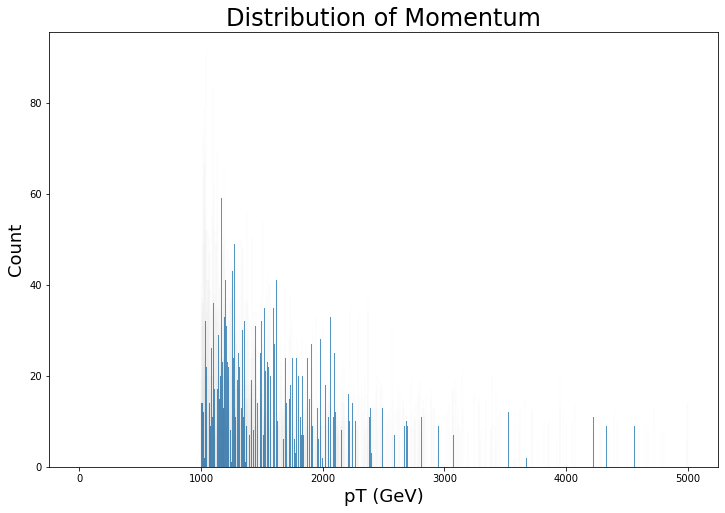

In [49]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.modulewise_true_edges[0]], binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [20]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

(Text(0.5, 1.0, 'Distribution of Hits per Particle'),
 Text(0.5, 0, 'Hits'),
 Text(0, 0.5, 'Count'))

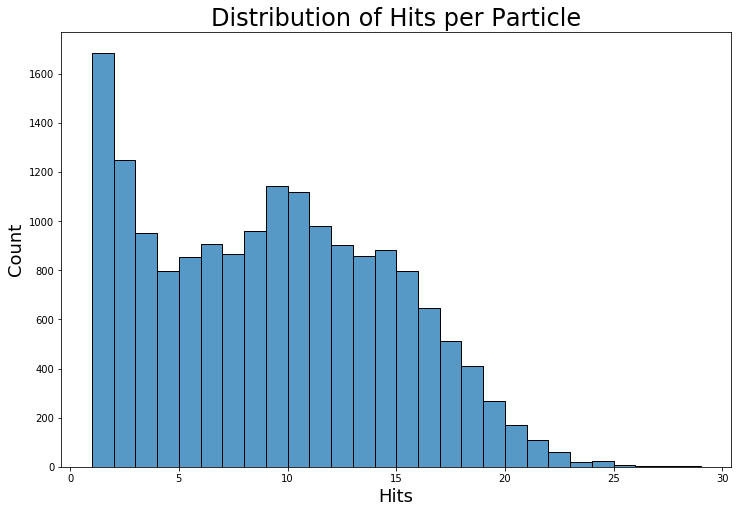

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[:-1], binwidth=1)
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

### Cell Info

In [20]:
cell_features = [
            "norm_x",
            "norm_y",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
            "eta_angle_1",
            "phi_angle_1",
            "eta_angle_2",
            "phi_angle_2",
            "pixel"
        ]

In [21]:
example_data.cell_data

tensor([[ 0.3610,  0.1495,  0.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000, -2.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  2.0000,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3239,  0.0059,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  0.5373,  0.0064,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3246,  0.0064,  0.0000]])

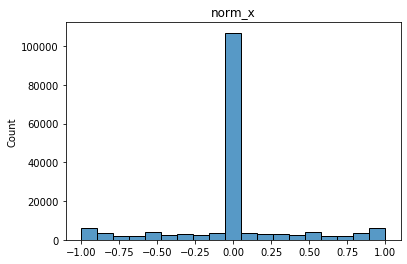

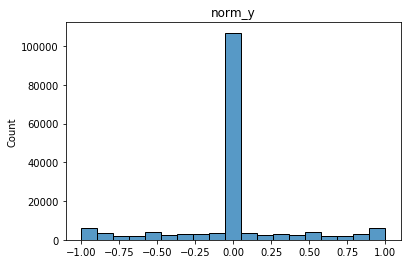

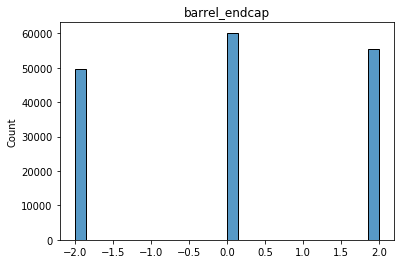

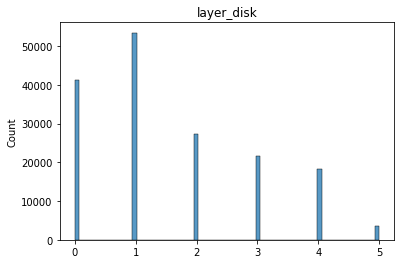

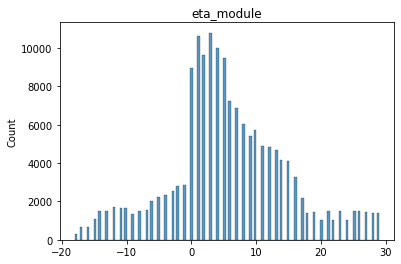

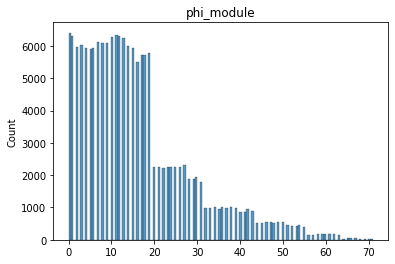

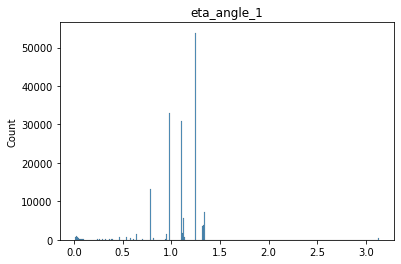

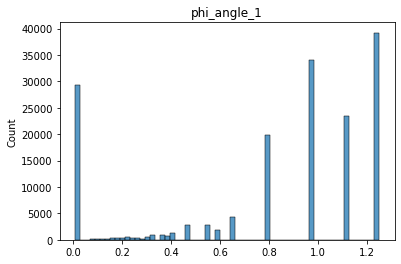

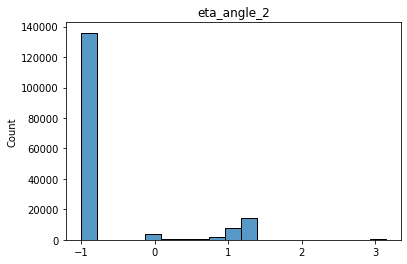

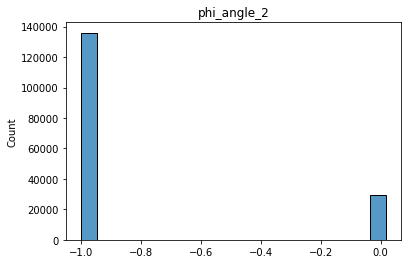

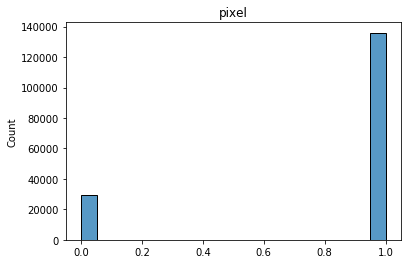

In [22]:
for i, feature in enumerate(cell_features):
    plt.figure()
    sns.histplot(example_data.cell_data[:, i].numpy()).set_title(feature)

## Metric Learning

### Train filter

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='eff',
    mode="max",
    save_top_k=2,
    save_last=True)

In [5]:
%%time
logger = WandbLogger(project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"])
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], num_sanity_val_steps=0, logger=logger, callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | input_layer  | Linear     | 23.6 K
1 | layers       | ModuleList | 656 K 
2 | output_layer | Linear     | 257   
3 | act          | Tanh       | 0     
--------------------------------------------
679 K     Trainable params
0         Non-trainable params
679 K     Total params
2.720     Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2h 16min 36s, sys: 5min 1s, total: 2h 21min 37s
Wall time: 26min 37s


### Test filter

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_0.5GeV_Barrel_Filter/h1ilzfy9/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

model = PyramidFilter.load_from_checkpoint(checkpoint_path).to(device)

In [4]:
model.eval();

In [5]:
model.hparams["datatype_split"] = [1, 1, 1]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0.5GeV_barrel"
model.setup(stage="fit")

In [5]:
test_results = model.to(device).shared_evaluation(model.valset[0].to(device), 0)
cut = 0.2

In [6]:
(test_results["preds"] > cut).sum()

tensor(229455, device='cuda:0')

In [7]:
(test_results["truth"] & (test_results["preds"] > cut)).sum()

tensor(16498, device='cuda:0')

In [8]:
(test_results["truth"] & (test_results["preds"] > cut)).sum() / (test_results["preds"] > cut).sum()

tensor(0.0719, device='cuda:0')

In [9]:
(test_results["truth"] & (test_results["preds"] > cut)).sum() / test_results["truth"].int().sum()

tensor(0.9927, device='cuda:0')

In [16]:
(test_results["truth"] & (test_results["preds"] > cut)).sum() / model.valset[0].signal_true_edges.shape[1]

tensor(0.9851, device='cuda:0')

In [82]:
subset_mask = np.isin(batch.edge_index.cpu(), batch.modulewise_true_edges.unique().cpu()).any(0)

In [59]:
test_results["preds"].cpu()[::100].shape

torch.Size([17586])

In [77]:
true_preds.shape

torch.Size([12035])

In [78]:
false_preds.shape

torch.Size([1746521])

In [87]:
true_preds = test_results["preds"][test_results["trues"].cpu() & subset_mask]
false_preds = test_results["preds"][~test_results["trues"].cpu() & subset_mask]

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  """Entry point for launching an IPython kernel.
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  


## Build Edges

In [6]:
class FilterInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]
        
        # Get [train, val, test] lists of files
        self.dataset_list = []
        for dataname in model.hparams["datatype_names"]:
            dataset = os.listdir(os.path.join(model.hparams["input_dir"], dataname))
            dataset = sorted([os.path.join(model.hparams["input_dir"], dataname, event) for event in dataset])
            self.dataset_list.append(dataset)
        

    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.dataset_list[0],
            "val": self.dataset_list[1],
            "test": self.dataset_list[2],
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for event_idx, event_file in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    batch = torch.load(event_file).to(device)
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        
        emb = (
            None if (self.model.hparams["emb_channels"] == 0) else batch.embedding
        )  # Does this work??

        cut_list = []
        for j in range(self.model.hparams["n_chunks"]):
            subset_ind = torch.chunk(torch.arange(batch.edge_index.shape[1]), self.model.hparams["n_chunks"])[
                j
            ]
            output = (
                self.model(
                    torch.cat([batch.cell_data[:, :self.model.hparams["cell_channels"]], batch.x], axis=-1),
                    batch.edge_index[:, subset_ind],
                    emb,
                ).squeeze()
                if ("ci" in self.model.hparams["regime"])
                else self.model(batch.x, batch.edge_index[:, subset_ind], emb).squeeze()
            )
            cut = torch.sigmoid(output) > self.model.hparams["filter_cut"]
            cut_list.append(cut)

        cut_list = torch.cat(cut_list)

        if "pid" not in self.model.hparams["regime"]:
            batch.y = batch.y[cut_list]

        y_pid = batch.pid[batch.edge_index[0]] == batch.pid[batch.edge_index[1]]
        batch.y_pid = y_pid[cut_list]
        batch.edge_index = batch.edge_index[:, cut_list]
        if "weighting" in self.model.hparams["regime"]:
            batch.weights = batch.weights[cut_list]

        self.save_downstream(batch, datatype)
        
        

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)

In [7]:
output_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0.5GeV_barrel"
model.hparams["train_split"] = [10, 1, 1]
model.hparams["filter_cut"] = 0.2

In [8]:
edge_builder = FilterInferenceBuilder(model, output_dir, overwrite=True)
    
edge_builder.build()

Training finished, running inference to build graphs...


## Debug Dataloader

In [16]:
from torch.utils.data import Dataset, DataLoader

In [5]:
from LightningModules.Filter.utils import load_dataset

In [107]:
class filter_dataset(Dataset):
    
    def __init__(self, dataset, hparams):
        
        # Setup here
        self.dataset = dataset
        self.hparams = hparams
        
    def __len__(self):
        
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        batch = self.dataset[idx]
        print(batch)
        
        print(batch.edge_index.device)
        
        if "subset" in self.hparams["regime"]:
            subset_mask = np.isin(batch.edge_index, batch.modulewise_true_edges.unique()).any(0)
            batch.edge_index = batch.edge_index[:, subset_mask]
            batch.y = batch.y[subset_mask]
            
        if self.hparams["ratio"] != 0:
            num_true, num_false = batch.y.bool().sum(), (~batch.y.bool()).sum()
            
            fake_indices = torch.where(~batch.y.bool())[0]
            
            fake_indices = fake_indices[torch.randint(len(fake_indices), (num_true.item() * self.hparams["ratio"], ))]

            true_indices = torch.where(batch.y.bool())[0]
            combined_indices = torch.cat([true_indices, fake_indices])
            
            # Shuffle indices:
            combined_indices = combined_indices[torch.randperm(len(combined_indices))]
            
        else:
            combined_indices = torch.range(batch.edge_index.shape[1])
        
        return {"x": batch.x, "cell_data": batch.cell_data, "edge_index": batch.edge_index[:, combined_indices], "y": batch.y[combined_indices]}

In [52]:
input_dirs = [None, None, None]
input_dirs[: len(hparams["datatype_names"])] = [
            os.path.join(hparams["input_dir"], datatype)
            for datatype in hparams["datatype_names"]
        ]
trainset, valset, testset = [
            load_dataset(input_dir, hparams["datatype_split"][i])
            for i, input_dir in enumerate(input_dirs)
        ]

In [108]:
train_dataset = filter_dataset(trainset, hparams)

In [109]:
trainloader = DataLoader(train_dataset)